In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import db_connection
import ast
import re

from mysql.connector import Error
#from orgelpredigt_analysis import Sermon, is_id
from orgelpredigt_analysis import Sermon, is_id

import folium
import json
import os

In [2]:
id = "E000082"

In [9]:
cursor, connection = db_connection.get_connection()

In [10]:
for i in ["E100134", "E100194", "E100033"]:
    try:
        cursor.execute(f"SELECT e10id, e10komponist, e10werk, e10kurztitel, e10textdichter, e10gattung, e10besetzung FROM e10_musikwerke WHERE e10id = '{i}'")
        column_names = [col[0] for col in cursor.description]
        results = cursor.fetchall()
        print(results)
        if results:
            data = [dict(zip(column_names, row))  
                for row in results][0]
            print(data)
        else:
            print(f"Query executed for {i}, but no data found.")
    except Error as e:
        print(f"Database error occurred for {i}:", e)
    except Exception as e:
        print(f"Unexpected error for {i}:", e)



[('E100134', 'Anton, Christoph ; Hintze, Jacob', 'Alle Menschen müssen sterben', '', 'Albinus, Johann Georg ; Rosenmüller, Johann', 'Kirchenlied', '')]
{'e10id': 'E100134', 'e10komponist': 'Anton, Christoph ; Hintze, Jacob', 'e10werk': 'Alle Menschen müssen sterben', 'e10kurztitel': '', 'e10textdichter': 'Albinus, Johann Georg ; Rosenmüller, Johann', 'e10gattung': 'Kirchenlied', 'e10besetzung': ''}
[('E100194', 'Spangeberg, Cyriakus', 'Christe, der du bist der helle Tag', '', 'Alber, Erasmus', 'Kirchenlied', '')]
{'e10id': 'E100194', 'e10komponist': 'Spangeberg, Cyriakus', 'e10werk': 'Christe, der du bist der helle Tag', 'e10kurztitel': '', 'e10textdichter': 'Alber, Erasmus', 'e10gattung': 'Kirchenlied', 'e10besetzung': ''}
[('E100033', 'Anonym', 'Ach Gott wie manches Herzeleid', '', 'Moller, Martin', 'Kirchenlied', '')]
{'e10id': 'E100033', 'e10komponist': 'Anonym', 'e10werk': 'Ach Gott wie manches Herzeleid', 'e10kurztitel': '', 'e10textdichter': 'Moller, Martin', 'e10gattung': 'Kirc

In [3]:
sermon = Sermon(id)

In [4]:
links = [item for item in sermon.all_references if is_id(item)]

In [5]:
from collections import Counter

In [6]:
cursor.execute(f"SELECT * FROM e10_musikwerke WHERE e10id = 'E100155'")
#cursor.execute(f"SELECT e10id, e10komponist, e10werk, e10kurztitel, e10textdichter, e10gattung, e10besetzung FROM e10_musikwerke WHERE e10id = 'E100155'")
column_names = [col[0] for col in cursor.description]
results = cursor.fetchall()
results

NameError: name 'cursor' is not defined

In [7]:
for i in sermon.literaturzitate:
    print(i["item"])

Plautus, M. Accius: Marci Accii Plauti Comoediae (London: 1874)
Luther, Martin: Enchiridion (Frankfurt an der Oder: 1601)
Polus, Timotheus: Neu-Vermehrter Lustiger Schawplatz (Lübeck ; Ratzeburg: 1664)
Augustinus, Aurelius ; Thimme, Wilhelm (Übers.): Confessiones. Bekenntnisse (Düsseldorf ; Zürich: 2004)
Sachs, Michael: Alphabetum historicvm (Leipzig: 1617)


In [9]:
color_map = {
        'orgelpredigt': 'rgb(135, 44, 162)',
        'musikwerk': 'rgb(192, 54, 157)',
        'literatur': 'rgb(234, 79, 136)',
        'quelle': 'rgb(250, 120, 118)',
        'bibel': 'rgb(246, 169, 122)',
        'nan': 'rgb(237, 217, 163)',
        'text': 'rgb(237, 217, 163)'
    }

In [10]:
import plotly.express as px
import plotly.graph_objects as go

In [11]:
def generate_normalized_gradient(rgb, n):
    """
    Generate a list of `n` normalized RGB gradient values
    that fade from black to the input `rgb` color.

    Parameters:
        rgb (tuple): A tuple of 3 integers (R, G, B), each 0-255.
        n (int): Number of gradient steps.

    Returns:
        list of tuples: Each tuple contains normalized (R, G, B) values.
    """
    rgb = tuple(int(x) for x in rgb[4:-1].split(", "))
    print(rgb)
    if not (isinstance(rgb, tuple) and len(rgb) == 3 and all(0 <= val <= 255 for val in rgb)):
        raise ValueError("RGB must be a tuple of three integers between 0 and 255.")
    if n <= 0:
        raise ValueError("Number of gradient steps must be positive.")
    
    gradient = []
    for i in range(n):
        ratio = i / (n - 1) if n > 1 else 1
        r = (rgb[0] * ratio) / 255
        g = (rgb[1] * ratio) / 255
        b = (rgb[2] * ratio) / 255
        gradient.append((r, g, b))
    print(gradient)
    return gradient

lit_labels = []
lit_data = []
lit_titel = []
lit_wordshare = []
lit_wordfraction = []
orgel_labels = []
orgel_data = []
orgel_titel = []
orgel_wordshare = []
orgel_wordfraction = []
musik_labels = []
musik_data = []
musik_titel = []
musik_wordshare = []
musik_wordfraction = []
for quelle in sermon.literaturzitate:
    lit_titel.append(str(quelle["item"]))
    lit_wordshare.append(quelle["word_share"])
    lit_wordfraction.append(float("{:.4f}".format((quelle["word_share"]/len(sermon.words))*100)))
    lit_labels.append(str(quelle["item"]))
    lit_data.append(quelle["word_share"])
for predigt in sermon.orgelpredigtzitate:
    orgel_titel.append(str(predigt["item"]))
    orgel_wordshare.append(predigt["word_share"])
    orgel_wordfraction.append(float("{:.4f}".format((predigt["word_share"]/len(sermon.words))*100)))
    orgel_labels.append(str(predigt["item"]))
    orgel_data.append(predigt["word_share"])
for musik in sermon.musikzitate:
    musik_titel.append(str(musik["item"]))
    musik_wordshare.append(musik["word_share"])
    musik_wordfraction.append(float("{:.4f}".format((musik["word_share"]/len(sermon.words))*100)))
    musik_labels.append(str(musik["item"]))
    musik_data.append(musik["word_share"])


labels = []
values = []
colors = []
for item, broad_color in zip([[lit_labels, lit_data], [orgel_labels, orgel_data], [musik_labels, musik_data]], ['quelle', 'orgelpredigt', 'musikwerk']):
    print(item[0])
    #for x,y  in item[0], item[1]:
    labels += item[0]
    values += item[1]
    colors += generate_normalized_gradient(color_map[broad_color], len(labels))

quotations_piechart = go.Figure(go.Pie(values=values, 
                             labels=labels, 
                             marker=dict(colors=colors),
                             title='Verwendete Zitate'))

quotations_piechart.update_layout(
    width=700,
    height=700,
    margin=dict(t=80, b=50, l=50, r=50),
    title_x=0.5,  # Center title
    legend=dict(
        orientation="h",  # horizontal legend
        y=-0.1  # push legend below chart
    )
)

['Plautus, M. Accius: Marci Accii Plauti Comoediae (London: 1874)', 'Luther, Martin: Enchiridion (Frankfurt an der Oder: 1601)', 'Polus, Timotheus: Neu-Vermehrter Lustiger Schawplatz (Lübeck ; Ratzeburg: 1664)', 'Augustinus, Aurelius ; Thimme, Wilhelm (Übers.): Confessiones. Bekenntnisse (Düsseldorf ; Zürich: 2004)', 'Sachs, Michael: Alphabetum historicvm (Leipzig: 1617)']
(250, 120, 118)
[(0.0, 0.0, 0.0), (0.24509803921568626, 0.11764705882352941, 0.11568627450980393), (0.49019607843137253, 0.23529411764705882, 0.23137254901960785), (0.7352941176470589, 0.35294117647058826, 0.34705882352941175), (0.9803921568627451, 0.47058823529411764, 0.4627450980392157)]
[]
(135, 44, 162)
[(0.0, 0.0, 0.0), (0.1323529411764706, 0.043137254901960784, 0.1588235294117647), (0.2647058823529412, 0.08627450980392157, 0.3176470588235294), (0.39705882352941174, 0.12941176470588237, 0.4764705882352941), (0.5294117647058824, 0.17254901960784313, 0.6352941176470588)]
['Gastoldi, Giovanni: Jesu, wollst uns weis

In [19]:
cursor, connection = db_connection.get_connection()

In [12]:
def is_id(value):
    pattern = re.compile(r'E[01][0-9]{5}')
    if re.match(pattern, value):
        return True
    else:
        return False

In [13]:
str(sermon.verleger)

'Kirsch'

In [14]:
author_network = sermon.autor.get_personal_network()

In [15]:
sermon_locations = {
    sermon.einweihungsort.name : sermon.einweihungsort.koordinaten,
    sermon.verlagsort.name : sermon.verlagsort.koordinaten
}

In [16]:
import plotly.express as px
import math
import pandas

In [17]:
labels

['Plautus, M. Accius: Marci Accii Plauti Comoediae (London: 1874)',
 'Luther, Martin: Enchiridion (Frankfurt an der Oder: 1601)',
 'Polus, Timotheus: Neu-Vermehrter Lustiger Schawplatz (Lübeck ; Ratzeburg: 1664)',
 'Augustinus, Aurelius ; Thimme, Wilhelm (Übers.): Confessiones. Bekenntnisse (Düsseldorf ; Zürich: 2004)',
 'Sachs, Michael: Alphabetum historicvm (Leipzig: 1617)',
 'Gastoldi, Giovanni: Jesu, wollst uns weisen',
 'Luther, Martin: Ein feste Burg ist unser Gott',
 'anonym: Komm, Gott Schöpfer, Heiliger Geist',
 'Anonym: O Christe, Wahrheit und Leben',
 'Luther, Martin: Aus tiefer Not schrei ich zu dir',
 'Anonym: Komm, Heiliger Geist, Herre Gott',
 'anonym: Herzlich tut mich erfreuen',
 'Luther, Martin: Vater unser im Himmelreich',
 'anonym: Veni, Sancte Spiritus',
 'Anonym: Kommt her zu mir, spricht Gottes Sohn',
 'anonym: So offt ich gedenck an Jüngsten Tag',
 'anonym: Es stehn vor Gottes Throne']

In [18]:
occurrences = {i:sermon.word_types.count(i) for i in set(sermon.word_types)}

labels = []
data = []
for label, number in occurrences.items():
    if pandas.isnull(label):
    #if math.isnan(int(label)):
        labels.append("text")
    else:
        labels.append(label.strip())
    data.append(number)

fig = px.pie(values=data, names=labels, title='My Pie Chart')
fig.show()

In [19]:
all_refs = sum(sermon.reference, [])
all_refs

['Weish_11-21',
 'Weish_11-21',
 'Weish_11-21',
 'Weish_11-21',
 'Weish_11-21',
 'Weish_11-21',
 'Weish_11-21',
 'Weish_11-21',
 'Ps_111-3',
 'Ps_111-3',
 'Ps_111-3',
 'Ps_111-3',
 'Ps_111-3',
 'Ps_111-3',
 'Ps_111-3',
 'Ps_111-3',
 'Ps_150',
 'Ps_150',
 'Ps_150',
 'Ps_150',
 'Ps_150',
 'Ps_150',
 'Ps_150',
 'Ps_150',
 'Ps_150',
 'Ps_150',
 'Ps_150',
 'Ps_150',
 'Ps_150',
 'Ps_150',
 'Ps_150',
 'Ps_150',
 'Ps_150',
 'Ps_150',
 'Ps_150',
 'Ps_150',
 'Ps_150',
 'Ps_150',
 'Ps_150',
 'Ps_150',
 'Ps_150',
 'Ps_150',
 'Ps_150',
 'Ps_150',
 'Ps_150',
 'Ps_150',
 'Ps_150',
 'Ps_150',
 'Ps_150',
 'Ps_150',
 'Ps_150',
 'Ps_150',
 'Ps_150',
 'Ps_150',
 'Ps_150',
 'Ps_150',
 'Ps_150',
 'Ps_150',
 'Ps_150',
 'Ps_150',
 'Ps_150',
 'Ps_150',
 'Ps_150',
 'Ps_150',
 'Ps_150',
 'Ps_150',
 'Ps_150',
 'Ps_150',
 'Ps_150',
 'Ps_150',
 'Ps_150',
 'Ps_150',
 'Ps_150',
 'Ps_150',
 'Ps_150',
 'Ps_150',
 'Ps_150',
 'Ps_150',
 'Ps_150',
 'Ps_150',
 'Ps_150',
 'Ps_150',
 'Ps_150',
 'Ps_150',
 'Ps_150',
 'Ps_150'

In [20]:
len(sermon.words)

8023

In [21]:
for quelle in sermon.literaturzitate:
    print(str(quelle["item"]), quelle["word_share"])

Plautus, M. Accius: Marci Accii Plauti Comoediae (London: 1874) 1307
Luther, Martin: Enchiridion (Frankfurt an der Oder: 1601) 73
Polus, Timotheus: Neu-Vermehrter Lustiger Schawplatz (Lübeck ; Ratzeburg: 1664) 66
Augustinus, Aurelius ; Thimme, Wilhelm (Übers.): Confessiones. Bekenntnisse (Düsseldorf ; Zürich: 2004) 22
Sachs, Michael: Alphabetum historicvm (Leipzig: 1617) 38


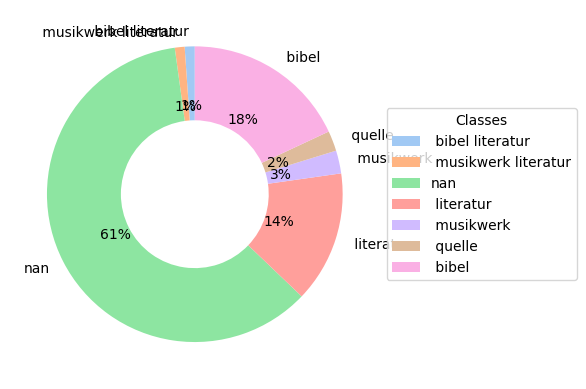

In [22]:
# plotting data on chart
occurrences = {i:sermon.word_types.count(i) for i in set(sermon.word_types)}

labels = []
data = []
for label, number in occurrences.items():
    labels.append(label)
    data.append(number)

colors = sns.color_palette('pastel')

fig, ax = plt.subplots()

wedges, texts, autotexts = ax.pie(
    data,
    labels=labels,
    colors=colors,
    startangle=90,
    autopct='%.0f%%',
    wedgeprops=dict(width=0.5)
)

ax.legend(wedges, labels, title="Classes", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
plt.show()


In [23]:
from pprint import pprint

In [25]:
def generate_quotation_text(words, labels, references):
    text = '<!DOCTYPE html>\n<html lang="en">\n<head>\n<meta charset="UTF-8">\n<meta name="viewport" content="width=device-width, initial-scale=1.0">\n<title>HTML 5 Boilerplate</title><link rel="stylesheet" href="style.css"></head><body><p>'
    for word, label, ref in zip(words, labels, str(references)):
        text += f'<span class="{label}" ref="{ref}">{word}</span> '
    text += '</p></body></html>'
    return text

In [26]:
labels = sermon.word_types

def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

pprint(list(chunks(range(10, 75), 10)))


[range(10, 20),
 range(20, 30),
 range(30, 40),
 range(40, 50),
 range(50, 60),
 range(60, 70),
 range(70, 75)]


In [27]:
literaturliste = ""
lit_labels = []
lit_data = []
lit_titel = []
lit_wordshare = []
lit_wordfraction = []
for quelle in sermon.literaturzitate:
    lit_titel.append(str(quelle["item"]))
    lit_wordshare.append(quelle["word_share"])
    lit_wordfraction.append("{:.4f}%".format((quelle["word_share"]/len(sermon.words))*100))
    lit_labels.append(str(quelle["item"]))
    lit_data.append(quelle["word_share"])

In [28]:
literatur = pd.DataFrame(
    {'Titel': lit_titel,
     'Länge': lit_wordshare,
     'Anteil': lit_wordfraction
    })
literatur

,Titel,Länge,Anteil
0,"Plautus, M. Accius: Marci Accii Plauti Comoedi...",1307,16.2907%
1,"Luther, Martin: Enchiridion (Frankfurt an der ...",73,0.9099%
2,"Polus, Timotheus: Neu-Vermehrter Lustiger Scha...",66,0.8226%
3,"Augustinus, Aurelius ; Thimme, Wilhelm (Übers....",22,0.2742%
4,"Sachs, Michael: Alphabetum historicvm (Leipzig...",38,0.4736%


In [29]:
custom_labels = [
    f"{label}: {value / len(sermon.words) * 100:.1f}%" if (value / len(sermon.words) * 100) > 5 else ''
    for label, value in zip(lit_labels, lit_data)
]

fig2 = px.pie(values=lit_data, names=lit_labels, title='Verwendete Zitate')



fig2.update_layout(
    width=700,
    height=700,
    margin=dict(t=80, b=50, l=50, r=50),
    title_x=0.5,  # Center title
    legend=dict(
        orientation="h",  # horizontal legend
        y=-0.1  # push legend below chart
    )
)

fig2.show()

In [30]:
len(sermon.words)

8023

In [31]:
overhang = len(sermon.words) % 100
-overhang

-23

In [32]:
quote_distribution_chunked = go.Figure(layout=dict(barmode='stack'))

for row, nr in zip(chunked_types, range(1, len(chunked_types))):
    item = dict(Counter(row))
    bar_title = f"Wörter 1 bis 100" if nr == 1 else f"Wörter {nr * 100} bis {(nr * 100) +100}"
    for key, val in item.items():
        quote_distribution_chunked.add_trace(go.Bar(
            name=str(key).strip(), 
            x=[bar_title], 
            y=[val],
            marker_color=color_map.get(str(key).strip(), 'gray')
            ))

quote_distribution_chunked.update_layout(barmode='stack')

NameError: name 'chunked_types' is not defined

In [33]:
from collections import Counter
import plotly.graph_objects as go

In [34]:
##### quotation distribution over sermon in 100-Word-Chunks
overhang = len(sermon.words) % 100 
chunked_types=[]
for i in range(0,len(sermon.words),100):
    types = ["text" if isinstance(x, float) else x for x in sermon.word_types[i:i+100]]
    reference = [" ".join(ref) for ref in sermon.reference[i:i+100]]
    concat = [",".join(zipped) for zipped in list(zip(types, reference))]
    chunked_types.append(concat)

last_types = ["" if isinstance(x, float) else x for x in sermon.word_types[-overhang:]]
last_refs = [" ".join(ref) for ref in sermon.reference[-overhang:]]
last_concat = [",".join(zipped) for zipped in list(zip(last_types, last_refs))]
chunked_types.append(last_types)

In [35]:
Counter(chunked_types[21])

Counter({'text,Ps_150': 70,
         ' bibel,Ps_150 Eph_2-20.21': 17,
         ' bibel,Ps_150 2Petr_1-21': 7,
         ' bibel,Ps_150 1Kor_3-6': 6})

In [36]:
fig = go.Figure(layout=dict(barmode='stack'))

In [37]:
overhang = len(sermon.words) % 100

In [38]:
color_map = {
    'orgelpredigt': 'rgb(135, 44, 162)',
    'musikwerk': 'rgb(192, 54, 157)',
    'literatur': 'rgb(234, 79, 136)',
    'quelle': 'rgb(250, 120, 118)',
    'bibel': 'rgb(246, 169, 122)',
    'nan': 'rgb(237, 217, 163)',
    'text': 'rgb(237, 217, 163)'
    }

In [39]:
fig = go.Figure(layout=dict(barmode='stack'))

for row, nr in zip(chunked_types, range(1, len(chunked_types))):
    item = dict(Counter(row))
    bar_title = f"Wörter 1 bis 100" if nr == 1 else f"Wörter {nr * 100} bis {(nr * 100) +100}"
    for key, val in item.items():
        color, ref = key.split(',')
        fig.add_trace(go.Bar(
            name=("https://orgelpredigt.ur.de/"+ str(ref).strip()) if is_id(ref) else str(key)[:-1].strip(), 
            x=[bar_title], 
            y=[val],
            marker_color=color_map.get(str(color).strip(), 'gray')
            ))

fig.update_layout(barmode='stack',
                  width=1400,
                  height=500)

fig.show()

In [40]:
def create_stacked_chart(sermon):

    overhang = len(sermon.words) % 100 
    chunked_types=[]
    for i in range(0,len(sermon.words),100):
        types = ["text" if isinstance(x, float) else x for x in sermon.word_types[i:i+100]]
        reference = [" ".join(ref) for ref in sermon.reference[i:i+100]]
        concat = [",".join(zipped) for zipped in list(zip(types, reference))]
        chunked_types.append(concat)

    last_types = ["" if isinstance(x, float) else x for x in sermon.word_types[-overhang:]]
    last_refs = [" ".join(ref) for ref in sermon.reference[-overhang:]]
    last_concat = [",".join(zipped) for zipped in list(zip(last_types, last_refs))]
    chunked_types.append(last_concat)

    quote_distribution_chunked = go.Figure(layout=dict(barmode='stack'))

    for row, nr in zip(chunked_types, range(1, len(chunked_types))):
        item = dict(Counter(row))
        bar_title = f"Wörter 1 bis 100" if nr == 1 else f"Wörter {nr * 100} bis {(nr * 100) +100}"
        for key, val in item.items():
            colors, ref = key.split(',')
            colors = colors.strip().split(" ")
            if len(colors) > 1:
                color = colors[1] if is_id(colors[1]) else colors[0]
            else:
                color = colors[0]
            name = f'{str(ref).strip()}' if is_id(ref) else str(key).replace(',', '').strip()
            url=f'https://orgelpredigt.ur.de/{str(ref).strip()}' if is_id(ref) else ""
            quote_distribution_chunked.add_trace(go.Bar(
                name=name, 
                x=[bar_title], 
                y=[val],
                hovertemplate=f'<b>{name}</b><br>Value: {val} Words<br>Link: <a href="{url}">{ref}</a><extra></extra>',
                marker_color=color_map.get(str(color).strip(), 'gray')
                ))

    quote_distribution_chunked.update_layout(barmode='stack',
                                             width=1500,
                                             height=500)
    
    return quote_distribution_chunked

In [41]:
x = create_stacked_chart(sermon)
x

In [42]:
fig.update_layout(barmode='stack')

fig.show()

In [43]:
cursor.execute(f"SELECT e00id, e00kurztitel, e00jahr FROM e00_orgelpredigten")
results = cursor.fetchall()
print(results)

NameError: name 'cursor' is not defined

In [52]:
predigten_übersicht = {}
for i in results:
    a = {}
    a["title"] = i[1]
    a["year"] = i[2]
    predigten_übersicht[i[0]] = a

In [53]:
path = 'sermon_tables/'
files = [file[:-4] for file in os.listdir(path)]

In [54]:
files

['E000020',
 'E000075',
 'E000003',
 'E000083',
 'E000069',
 'E000024',
 'E000046',
 'E000038',
 'E000061',
 'E000015',
 'E000098',
 'E000035',
 'E000055',
 'E000045',
 'E000021',
 'E000072',
 'E000086',
 'E000016',
 'E000085',
 'E000009',
 'E000082',
 'E000051',
 'E000039',
 'E000096',
 'E000036',
 'E000099',
 'E000073',
 'E000027',
 'E000060',
 'E000002',
 'E000109',
 'E000089',
 'E000074',
 'E000058',
 'E000053',
 'E000070',
 'E000042',
 'E000091',
 'E000057',
 'E000104',
 'E000078',
 'E000001',
 'E000037',
 'E000007',
 'E000108',
 'E000030',
 'E000068',
 'E000008',
 'E000034',
 'E000090',
 'E000014',
 'E000067',
 'E000059',
 'E000095',
 'E000041',
 'E000092',
 'E000052',
 'E000063',
 'E000056',
 'E000048',
 'E000029',
 'E000065',
 'E000106',
 'E000023',
 'E000079']

In [55]:
for i in files:
    if i not in predigten_übersicht:
        print(i)
        del predigten_übersicht[i]

In [56]:
print(predigten_übersicht)

{'E000001': {'title': 'Christliche Predigt (Tübingen 1602)', 'year': '1602'}, 'E000002': {'title': 'Musica instrumentalis (Meißen 1605)', 'year': '1605'}, 'E000003': {'title': 'Vlmische Orgel Predigt (Ulm 1624)', 'year': '1624'}, 'E000004': {'title': 'Vlmische Orgel Predigt (Ulm / Frankfurt a. M. 1625)', 'year': '1625'}, 'E000005': {'title': 'Kirchweih= oder Orgel=Predigt (Leipzig 1632)', 'year': '1632'}, 'E000006': {'title': 'Eine Predigt bey der Einweihung der neuerbauten Orgel (Magdeburg 1798)', 'year': '1798'}, 'E000007': {'title': 'Predigt bey der feyerlichen Einweihung der neuen Orgel (Magdeburg 1798)', 'year': '1798'}, 'E000008': {'title': 'Predigt Bey der Einweihung einer Orgel (Leipzig 1797)', 'year': '1797'}, 'E000009': {'title': 'Predigt bey Einweyhung der Orgel (s.l. 1795)', 'year': '1795'}, 'E000010': {'title': 'Ermunterung den öffentlichen Gottesdienst in Ehren zu halten (Frankfurt an der Oder s.a.)', 'year': '1789 [s.a.]'}, 'E000011': {'title': 'Die grossen Vortheile ein

In [57]:
predigten_übersicht = {k: v for k, v in predigten_übersicht.items() if k in files}

In [58]:
with open("predigten_übersicht.json", "w") as file: 
    json.dump(predigten_übersicht, file, ensure_ascii=False, indent=2)

In [59]:
with open("predigten_übersicht.json", "r", encoding="utf-8") as file: 
    data = json.load(file)

In [60]:
data['E000001']['year']

'1602'

In [61]:
# Ensure all entries have a 'year' key
cleaned = {k: v for k, v in data.items() if 'year' in v}

year_finder = re.compile(r'[0-9]{4}')

for k, v in data.items():
    year = re.findall(year_finder, v['year'])[0]
    if year:
        v['year'] = year
    else:
        v['year'] = '[s.a.]'

# Convert to nested list and sort by year
relevant_sermons = sorted(
    [[key, value['title'], int(value['year'])] for key, value in cleaned.items()],
    key=lambda x: x[2]
)

print(relevant_sermons)


[['E000001', 'Christliche Predigt (Tübingen 1602)', 1602], ['E000002', 'Musica instrumentalis (Meißen 1605)', 1605], ['E000029', 'Christliche Predigt (Tübingen 1606)', 1606], ['E000030', 'Elogium Organi Musici (Altenburg 1610)', 1610], ['E000099', 'Corona Templi (Nürnberg 1621)', 1621], ['E000003', 'Vlmische Orgel Predigt (Ulm 1624)', 1624], ['E000098', 'Musica ecclesiastica (Stettin 1628)', 1628], ['E000096', 'Kostbare Bosische Orgel (Zwickau 1647)', 1647], ['E000095', 'Längst=gewüntzschte Mittweidische Orgel=Freude (Dresden 1648)', 1648], ['E000092', 'Organologismos (Dresden 1651)', 1651], ['E000091', 'Stolpenische Ehren-Crone (Dresden 1652)', 1652], ['E000090', 'Organolustria Evangelico-Stambachiana (Hof 1660)', 1660], ['E000089', 'Encoenia HierOrganica (Halle 1664)', 1664], ['E000086', 'Orgel=Predigt (Arnstadt 1666)', 1666], ['E000085', 'Das fröliche Hallelujah (Halle 1667)', 1667], ['E000083', 'Das Gott=Lob=Schallende Hosianna (Leipzig 1671)', 1671], ['E000082', 'Geistliches Orgel

In [62]:
x = "Christliche Predigt (Tübingen 1602) -- E000001"
print(x[-7:])

E000001


In [63]:
sermon.reference
reference = [x for xs in sermon.reference for x in xs]
reference


['Weish_11-21',
 'Weish_11-21',
 'Weish_11-21',
 'Weish_11-21',
 'Weish_11-21',
 'Weish_11-21',
 'Weish_11-21',
 'Weish_11-21',
 'Ps_111-3',
 'Ps_111-3',
 'Ps_111-3',
 'Ps_111-3',
 'Ps_111-3',
 'Ps_111-3',
 'Ps_111-3',
 'Ps_111-3',
 'Ps_150',
 'Ps_150',
 'Ps_150',
 'Ps_150',
 'Ps_150',
 'Ps_150',
 'Ps_150',
 'Ps_150',
 'Ps_150',
 'Ps_150',
 'Ps_150',
 'Ps_150',
 'Ps_150',
 'Ps_150',
 'Ps_150',
 'Ps_150',
 'Ps_150',
 'Ps_150',
 'Ps_150',
 'Ps_150',
 'Ps_150',
 'Ps_150',
 'Ps_150',
 'Ps_150',
 'Ps_150',
 'Ps_150',
 'Ps_150',
 'Ps_150',
 'Ps_150',
 'Ps_150',
 'Ps_150',
 'Ps_150',
 'Ps_150',
 'Ps_150',
 'Ps_150',
 'Ps_150',
 'Ps_150',
 'Ps_150',
 'Ps_150',
 'Ps_150',
 'Ps_150',
 'Ps_150',
 'Ps_150',
 'Ps_150',
 'Ps_150',
 'Ps_150',
 'Ps_150',
 'Ps_150',
 'Ps_150',
 'Ps_150',
 'Ps_150',
 'Ps_150',
 'Ps_150',
 'Ps_150',
 'Ps_150',
 'Ps_150',
 'Ps_150',
 'Ps_150',
 'Ps_150',
 'Ps_150',
 'Ps_150',
 'Ps_150',
 'Ps_150',
 'Ps_150',
 'Kol_3-16',
 'Kol_3-16',
 'Kol_3-16',
 'Kol_3-16',
 'Kol_3-16',

In [64]:
unique_refs = set(reference)
for i in unique_refs:
    print(i)

1Kor_14-33.34.40
Lk_18-13
E100082
2Petr_1-21
Ex_5
Mt_22-30
Kol_3-16
Joh_20-29
E100086
Ps_12-1
Mt_10-42
Gal_5-22
Sir_35-21
Ps_111-3
E100085
Ps_51-12
Weish_11-21
Mt_14-4
Lk_8-15
Röm_10-10
Sach_11-7
1Tim_4-8
E100038
Röm_8-38.39
Eph_2-20.21
Ps_73-4
Mt_13-34.35
Ps_2-9
Ps_78-2
Offb_2
Joh_15-5
Ez_3-17
Eph_5-18.19
Mk_16-16
1Kor_3-9
Apg_2-2
Mt_13-24.25.26.27.28.29.30
Ps_13-2
Mt_5-16
Spr_18-10
Ps_150-5
Offb_9
Ps_32-1.2
Ps_150
Ps_95-8
Ps_4-1
2Tim_3-12
2Chr_20-28
E100013
Jer_5-3
Röm_8-16
1Petr_2-9
Ps_6
Ps_42-2
E100068
Ps_49-9
Hebr_10-36
Ps_51-14
Ps_50-15
Jak_2-14
Mt_24-30.31
E090560
Mt_16-18
Ps_6-1
Röm_8-14
Joh_3-8
Ps_91-4.11.12.14
Mt_4-8.9
E100039
Hebr_13-17
E080427
1Sam_16-23
Ps_143
Röm_10.17
Eph_1-22
Offb_1
Dan_12-3
Sir_25-1.2
E080425
E100083
Sir_1-16
1Kor_3-6
Offb_6-16.17
Jer_15-3
Mt_6-6
Ps_111-10
Ps_133-1.2
Apg_13-34
Jes_40-8
E090778
1Joh_4-20.21
2Kön_3-15
Jak_1-23
E100003
Ps_119-92
E100081
Sir_25-14
Ps_42-8
Röm_12-12
1Thess_4-16.17.18
Neh_12-27
1Petr_1-18.19
Sir_7-40
Apg_20-28
Ps_119-72
1Pet

In [65]:
for x in sermon.literaturzitate:
    print(str(x["item"]))

Augustinus, Aurelius ; Thimme, Wilhelm (Übers.): Confessiones. Bekenntnisse (Düsseldorf ; Zürich: 2004)
Luther, Martin: Enchiridion (Frankfurt an der Oder: 1601)
Polus, Timotheus: Neu-Vermehrter Lustiger Schawplatz (Lübeck ; Ratzeburg: 1664)
Plautus, M. Accius: Marci Accii Plauti Comoediae (London: 1874)
Sachs, Michael: Alphabetum historicvm (Leipzig: 1617)
